In [21]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output
from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap, ZFeatureMap

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42
np.random.default_rng(2021)

Generator(PCG64) at 0x256F976CB88

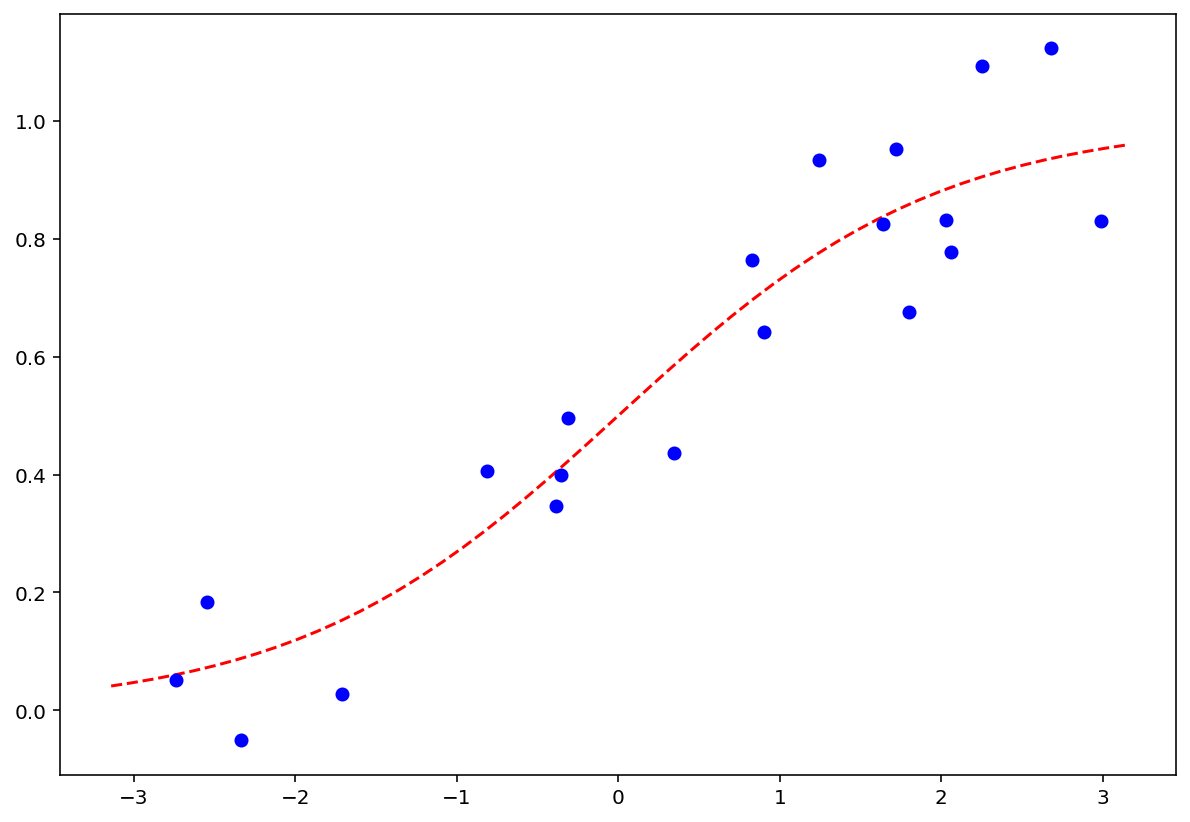

In [22]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x:  1/(1 + np.exp(-x))

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [23]:
X

array([[ 1.72131662],
       [-0.38403809],
       [ 2.25313718],
       [ 1.2400999 ],
       [-2.54985893],
       [ 2.98842337],
       [ 1.64078914],
       [ 1.79739504],
       [-2.33663096],
       [-0.31173435],
       [-0.81179996],
       [ 2.68144351],
       [ 0.90393121],
       [ 2.02797103],
       [-0.35553907],
       [-1.71380966],
       [ 0.34296633],
       [-2.74061701],
       [ 2.05856737],
       [ 0.82727182]])

In [24]:
y

array([ 0.95153344,  0.34696372,  1.09320001,  0.93282985,  0.18378936,
        0.82990387,  0.82433069,  0.67535305, -0.05014991,  0.49591104,
        0.40541193,  1.12292664,  0.64208684,  0.8318866 ,  0.39986218,
        0.02845878,  0.4368795 ,  0.05090073,  0.77757418,  0.76370336])

In [25]:
X_

array([[-3.14159265],
       [-3.01336438],
       [-2.88513611],
       [-2.75690784],
       [-2.62867957],
       [-2.5004513 ],
       [-2.37222302],
       [-2.24399475],
       [-2.11576648],
       [-1.98753821],
       [-1.85930994],
       [-1.73108167],
       [-1.60285339],
       [-1.47462512],
       [-1.34639685],
       [-1.21816858],
       [-1.08994031],
       [-0.96171204],
       [-0.83348377],
       [-0.70525549],
       [-0.57702722],
       [-0.44879895],
       [-0.32057068],
       [-0.19234241],
       [-0.06411414],
       [ 0.06411414],
       [ 0.19234241],
       [ 0.32057068],
       [ 0.44879895],
       [ 0.57702722],
       [ 0.70525549],
       [ 0.83348377],
       [ 0.96171204],
       [ 1.08994031],
       [ 1.21816858],
       [ 1.34639685],
       [ 1.47462512],
       [ 1.60285339],
       [ 1.73108167],
       [ 1.85930994],
       [ 1.98753821],
       [ 2.11576648],
       [ 2.24399475],
       [ 2.37222302],
       [ 2.5004513 ],
       [ 2

In [26]:
f(X_)

array([[0.04142383],
       [0.04682575],
       [0.05289325],
       [0.0596977 ],
       [0.06731531],
       [0.07582655],
       [0.0853155 ],
       [0.09586873],
       [0.10757382],
       [0.12051755],
       [0.1347835 ],
       [0.15044928],
       [0.16758319],
       [0.18624064],
       [0.20646007],
       [0.22825891],
       [0.25162952],
       [0.27653555],
       [0.30290895],
       [0.33064805],
       [0.35961692],
       [0.38964636],
       [0.42053668],
       [0.4520621 ],
       [0.48397695],
       [0.51602305],
       [0.5479379 ],
       [0.57946332],
       [0.61035364],
       [0.64038308],
       [0.66935195],
       [0.69709105],
       [0.72346445],
       [0.74837048],
       [0.77174109],
       [0.79353993],
       [0.81375936],
       [0.83241681],
       [0.84955072],
       [0.8652165 ],
       [0.87948245],
       [0.89242618],
       [0.90413127],
       [0.9146845 ],
       [0.92417345],
       [0.93268469],
       [0.9403023 ],
       [0.947

In [27]:
X.shape

(20, 1)

In [28]:
y.shape

(20,)

In [29]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)

In [30]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [31]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [32]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    #optimizer=L_BFGS_B(),
    optimizer=COBYLA(400),
    callback=callback_graph,
)

In [33]:
X.shape

(20, 1)

In [34]:
y.shape

(20,)

In [35]:
X_.shape

(50, 1)

In [36]:
f(X_).shape

(50, 1)

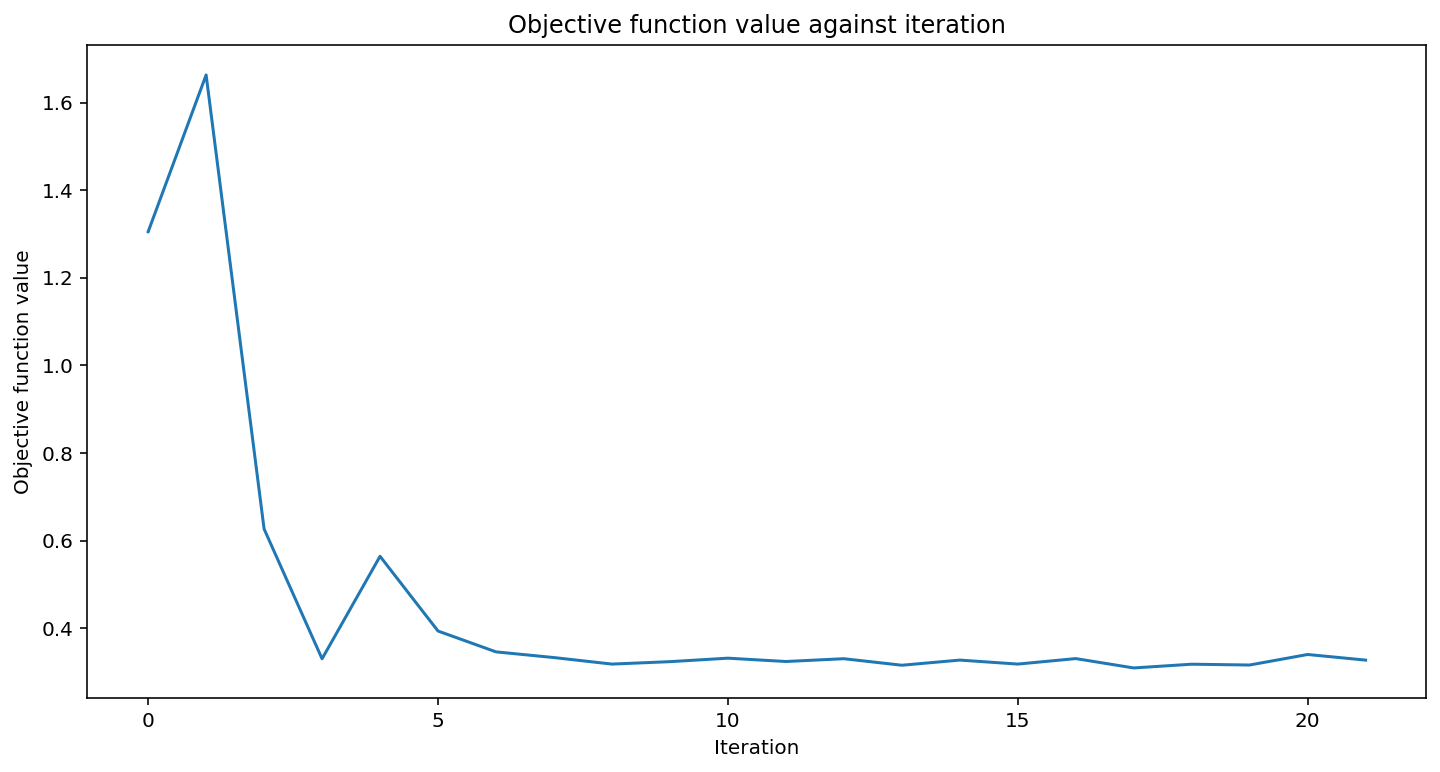

-1.7305866927364275

In [37]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score the result
regressor.score(X, y)

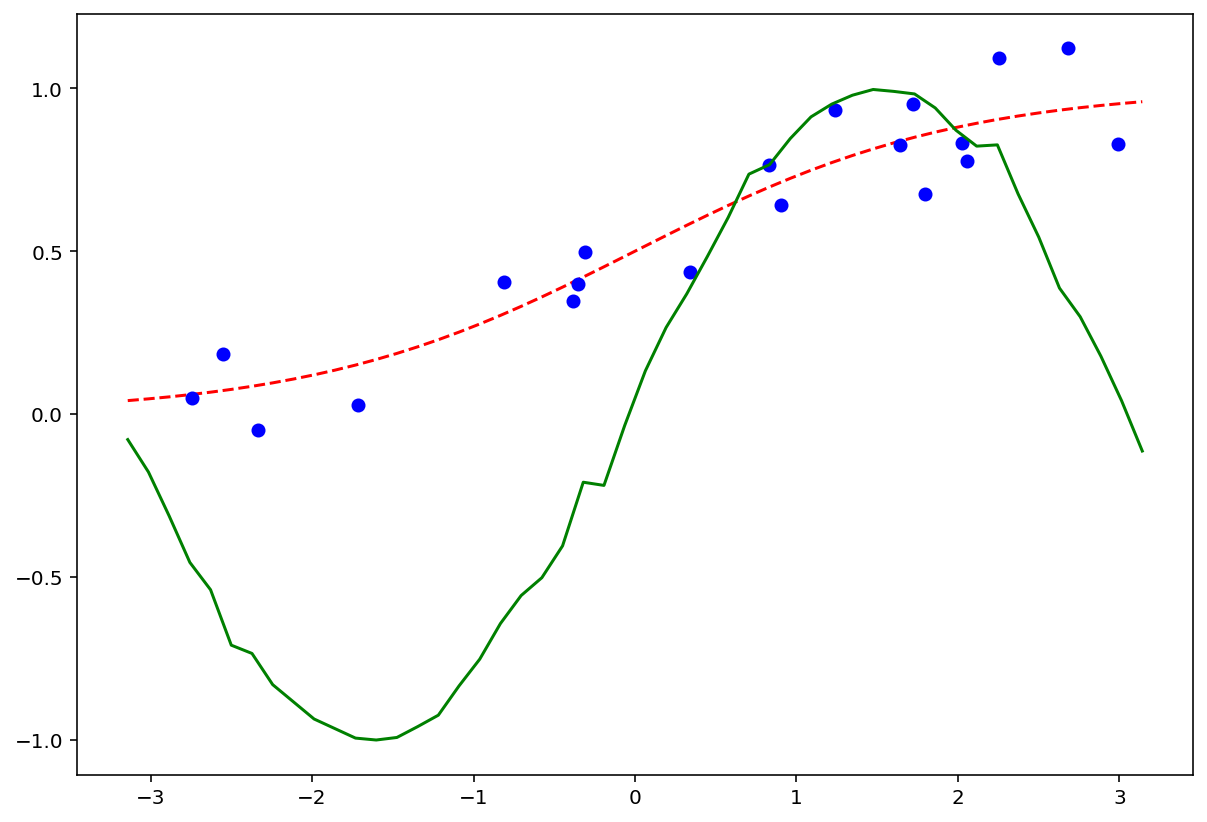

In [38]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [39]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

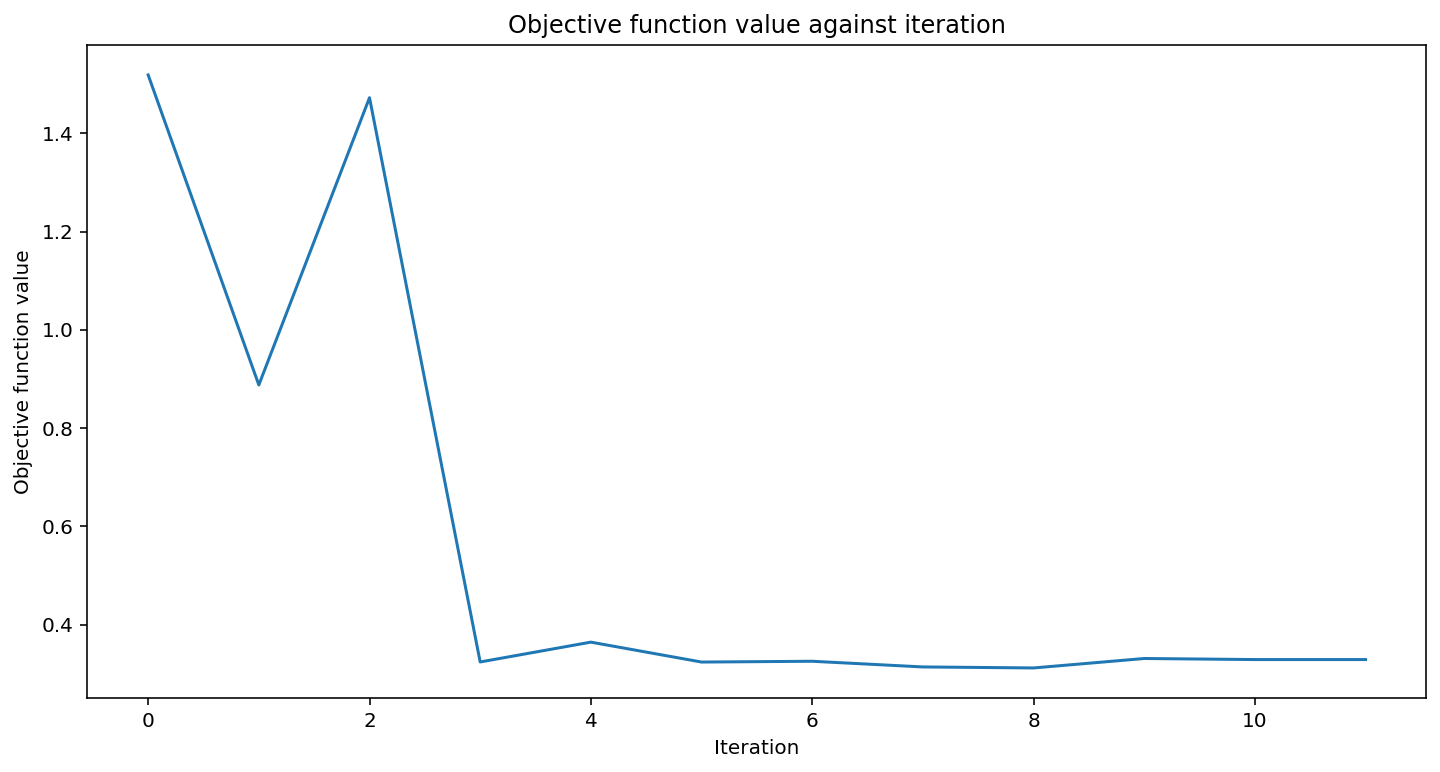

-1.7582066100151814

In [40]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score result
vqr.score(X, y)

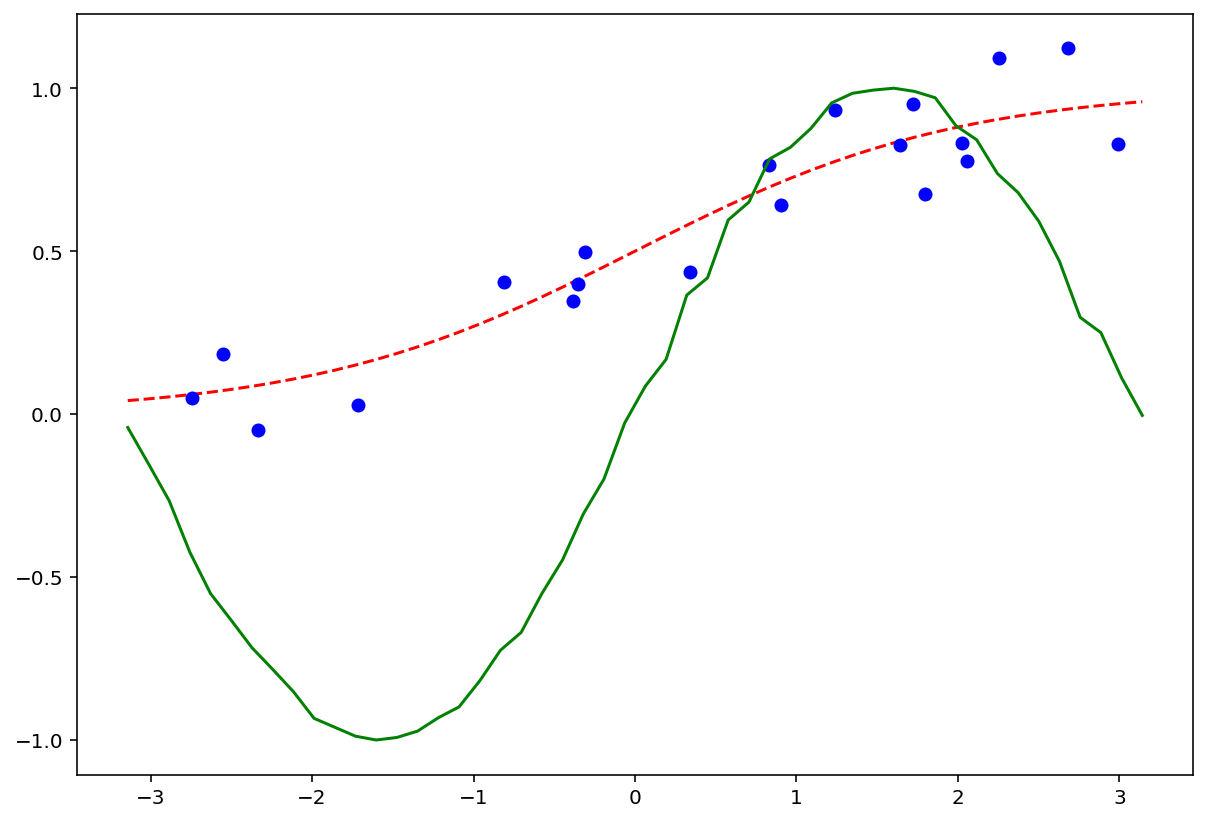

In [41]:
plt.rcParams['figure.figsize'] = [10, 7]

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

## Quantum Support Vector Regressor (Best Approach)

In [42]:
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

qsvr = QSVR(quantum_kernel=qkernel)
qsvr.fit(X, y)

QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000256D919BB48>,
     shrinking=True, tol=0.001, verbose=False)

In [43]:
qsvr.predict(X_)

array([0.47882249, 0.43648968, 0.39244709, 0.35632985, 0.30546567,
       0.2358288 , 0.27009932, 0.22137589, 0.11468219, 0.19054124,
       0.13534864, 0.15794632, 0.17701263, 0.05678936, 0.17296737,
       0.17765411, 0.04860611, 0.13170643, 0.23295024, 0.17631811,
       0.25892692, 0.27468043, 0.32100633, 0.36018466, 0.45781127,
       0.46881559, 0.50491553, 0.54641745, 0.59918265, 0.64362723,
       0.70665537, 0.69477989, 0.7094952 , 0.80679209, 0.80684659,
       0.7933802 , 0.79505129, 0.79461007, 0.7794833 , 0.80544689,
       0.79649988, 0.77538868, 0.80052099, 0.75615189, 0.69881407,
       0.62532593, 0.62358091, 0.62181441, 0.50693578, 0.5213273 ])

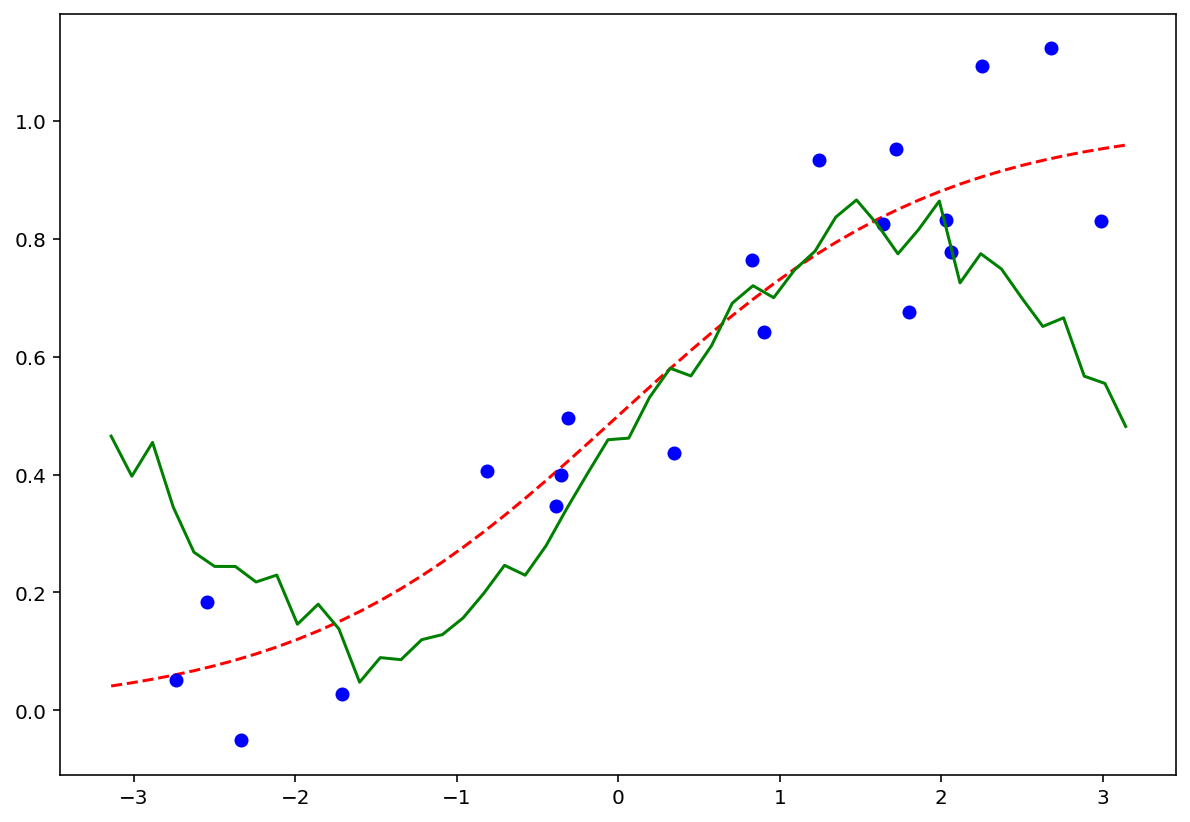

In [44]:
plt.rcParams['figure.figsize'] = [10, 7]

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = qsvr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()